In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import math

In [2]:
pitorch = torch.Tensor([math.pi])

In [3]:
def funU(x,y,beta):
    a = torch.tensor([-1,-1,-6.5,0.7])
    b = torch.tensor([0,0,11,0.6])
    c = torch.tensor([-10,-10,-6.5,0.7])
    D = torch.tensor([-200,-100,-170,15])
    X = torch.tensor([1,0,-0.5,-1])
    Y = torch.tensor([0,0.5,1.5,1])
    gamma = torch.tensor([9])
    k = torch.tensor([5])
  
    fx1 = D[0]*torch.exp(a[0]*((x-X[0]).pow(2)) + b[0]*(x-X[0])*(y-Y[0]) + c[0]*(y.pow(2)))
    fx2 = D[1]*torch.exp(a[1]*((x-X[1]).pow(2)) + b[1]*(x-X[1])*(y-Y[1]) + c[1]*((y-Y[1]).pow(2)))
    fx3 = D[2]*torch.exp(a[2]*((x-X[2]).pow(2)) + b[2]*(x-X[2])*(y-Y[2]) + c[2]*((y-Y[2]).pow(2)))
    fx4 = D[3]*torch.exp(a[3]*((x-X[3]).pow(2)) + b[3]*(x-X[3])*(y-Y[3]) + c[3]*((y-Y[3]).pow(2)))
#     extra = gamma*torch.sin(2*k*pitorch*x)*torch.sin(2*k*pitorch*y)
    
    U = fx1+fx2+fx3+fx4
#     U = U+extra
    
#     func_result = torch.exp(-beta*U)
    
    return U

In [4]:
class Model_estimate(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size,out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
#         self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        relu = nn.ReLU()
        tanhf = nn.Tanh()
        silu = nn.SiLU()
        
        out = tanhf(out)
        out = self.linear2(out)
        out = relu(out)
        out = self.linear3(out)
        out = relu(out)
#         out = self.linear4(out)
#         out = relu(out)
        
        return out

In [5]:
N_neuron = 40
input_size = 1
output_size = 1

NN_1 = Model_estimate(input_size,N_neuron,output_size)
NN_2 = Model_estimate(input_size,N_neuron,output_size)

In [6]:
num_pts = 3000
x1 = torch.FloatTensor(num_pts,1).uniform_(-1.55, 2.05)
x2 = torch.FloatTensor(num_pts,1).uniform_(-1.55, 2.05)
x1.requires_grad_(True)
x2.requires_grad_(True)

tensor([[-0.3480],
        [ 1.9460],
        [-0.6668],
        ...,
        [ 1.3887],
        [ 0.3045],
        [ 2.0431]], requires_grad=True)

In [7]:
def loss_fn(xx,yy,NN_1,NN_2,funcU,beta):
    # NN_1 and NN_2 are neural network models for x and y
    rhs = funcU(xx,yy,beta)
    psi_x = NN_1(xx)
    psi_y = NN_2(yy)
    psi_prodsum = torch.sum(psi_x+psi_y,dim = 1)[:,None]
    lossfn =nn.MSELoss()
    loss = lossfn(psi_prodsum,rhs)
    
    return loss 

In [8]:
loss_fn(x1,x2,NN_1,NN_2,funU,torch.tensor(1/10))

tensor(41815732., grad_fn=<MseLossBackward>)

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim


train_ds = TensorDataset(x1,x2)
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
optimizer1 = optim.Adam(NN_1.parameters(), lr=1e-6)
optimizer2 = optim.Adam(NN_2.parameters(), lr=1e-6)


In [10]:
beta = torch.tensor(1/10)
loss = 1
for epoch in range(100000):
    if epoch%100 == 0:
        print(epoch)
        print('loss: ',loss)
    for X1,X2 in train_dl:
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        loss = loss_fn(X1,X2,NN_1,NN_2,funU,beta)
        
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        
        

0
loss:  1


KeyboardInterrupt: 

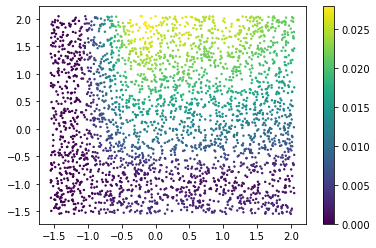

In [11]:
import matplotlib.pyplot as plt
rhs = funU(x1,x2,beta)
psi_x = NN_1(x1)
psi_y = NN_2(x2)
psi_prodsum = torch.sum(psi_x*psi_y,dim = 1)

# psi_prodsum_np = np.array(psi_prodsum)
# rhs_np = np.array(rhs)

plt.scatter(x1.detach().numpy(),x2.detach().numpy(), s=2.0, c=psi_prodsum.detach().numpy())

plt.colorbar()

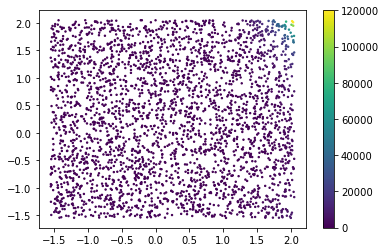

In [12]:
plt.scatter(x1.detach().numpy(),x2.detach().numpy(), s=2.0, c=rhs.detach().numpy())
plt.colorbar()
# plt.scatter(x1.detach().numpy(),rhs.detach().numpy())
# plt.scatter(x2.detach().numpy(),rhs.detach().numpy())

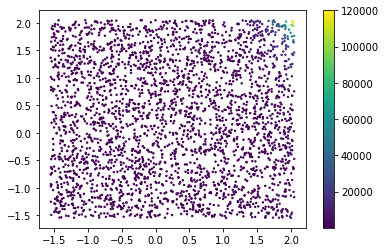

In [13]:
plt.scatter(x1.detach().numpy(),x2.detach().numpy(), s=2.0, c=torch.abs(psi_prodsum[:,None]-rhs).detach().numpy())
plt.colorbar()